<a href="https://colab.research.google.com/github/jcmachicao/MachineLearningAvanzado_UC_2025/blob/main/U4__SHAP_GradCAM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP demo

In [1]:
# Librerías necesarias
import torch
import torch.nn as nn
import shap
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Cargar datos de Iris
iris = load_iris()
X = iris.data
y = iris.target

# Convertir a problema binario (ejemplo simplificado)
y = (y > 1).astype(int)

In [3]:
# Preprocesamiento
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [4]:
# Modelo simple
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [5]:
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [6]:
X_train_np = X_train_tensor.cpu().detach().numpy()
X_test_np = X_test_tensor.cpu().detach().numpy()
masker = shap.maskers.Partition(X_train_np, max_samples=100)

# Convert the model to a callable function that accepts NumPy arrays
def model_func(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Convert to tensor inside the function
    with torch.no_grad():  # Disable gradient calculation for inference
        return model(X_tensor).cpu().detach().numpy()  # Convert output back to NumPy array

# Create a new explainer using the model function
explainer = shap.Explainer(model_func, masker)

# Calculate SHAP values using the NumPy array
shap_values = explainer(X_test_np)  # Pass X_test_np here

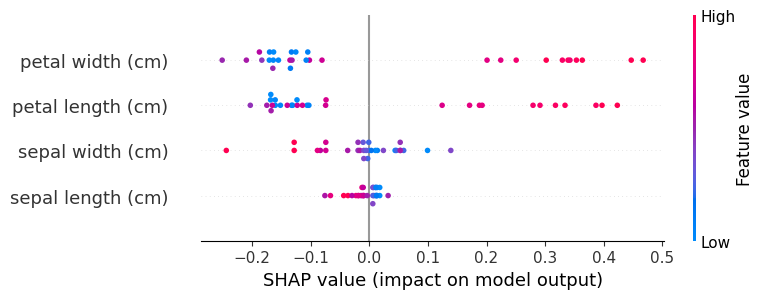

In [7]:
shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names)

# GradCAM Demo

GradCAM (Gradient-weighted Class Activation Mapping) con un ejemplo práctico.

El concepto de GradCAM se puede entender en estos pasos fundamentales:

1. Idea Principal:
- GradCAM identifica qué partes de una imagen de entrada fueron más importantes para la decisión del modelo
- Se enfoca en la última capa convolucional porque mantiene información espacial importante

2. Proceso Paso a Paso:

a) Forward Pass:
   - La imagen pasa por la red hasta obtener la predicción
   - Se guardan las activaciones de la última capa convolucional

b) Backward Pass:
   - Se calcula el gradiente respecto a la clase de interés
   - Los gradientes fluyen hacia atrás hasta la capa objetivo

c) Ponderación:
   - Se calculan pesos α para cada mapa de características:
   ```python
   alpha = gradients.mean(dim=(2, 3), keepdim=True)
   ```
   - Estos pesos capturan la "importancia" de cada canal

d) Generación del Mapa de Calor:
   - Se multiplican las activaciones por sus pesos correspondientes
   - Se suman todos los mapas ponderados
   - Se aplica ReLU para mantener solo las contribuciones positivas

3. Características Clave:

- Class-specific: Muestra qué regiones son importantes para una clase específica
- Localización: Mantiene la información espacial de la imagen original
- Interpretable: Produce un mapa de calor que se puede superponer a la imagen original

4. Aplicaciones:

- Debugging de modelos CNN
- Verificación de que el modelo "mira" las partes correctas
- Identificación de sesgos en el conjunto de datos
- Mejora de la confianza en las predicciones del modelo

¿Te gustaría que profundicemos en algún aspecto específico de GradCAM o que te muestre cómo se aplicaría a un caso de uso particular?

In [8]:
# Librerías necesarias
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Cargar MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 634kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.64MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# Modelo simple de CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = SimpleCNN()

In [11]:
# Usar una imagen de ejemplo
image, label = next(iter(loader))
image.requires_grad = True

# Forward pass
model.eval()
output = model(image)
pred_class = output.argmax(dim=1)


# Grad-CAM
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
output = model(image)
pred_class = output.argmax(dim=1)

In [12]:
activations = activation['conv2']
# Get gradients of the output with respect to the conv2 activations
output[:, pred_class].backward() # Calculate gradients

In [13]:
gradients_weight = model.conv2.weight.grad
gradients_bias = model.conv2.bias.grad

# Average gradients_weight across kernel dimensions and input channels
gradients_weight_averaged = torch.mean(gradients_weight, dim=(1, 2, 3))

# Unsqueeze to match dimensions of gradients_bias
gradients_weight_averaged = gradients_weight_averaged.unsqueeze(0)

# Repeat to match the number of output channels in gradients_bias
gradients_weight_averaged = gradients_weight_averaged.reshape(gradients_bias.shape[0])
gradients = (gradients_weight_averaged + gradients_bias) / 2

# Calculate Grad-CAM
weights = torch.mean(gradients, dim=(0))  # Average gradients across channels
grad_cam = torch.sum(weights * activations, dim=0).detach().numpy()  # Apply weights to activations

In [ ]:
# Normalize and visualize
grad_cam = np.maximum(grad_cam, 0)  # ReLU
grad_cam = grad_cam[0]
grad_cam /= grad_cam.max()  # Normalize

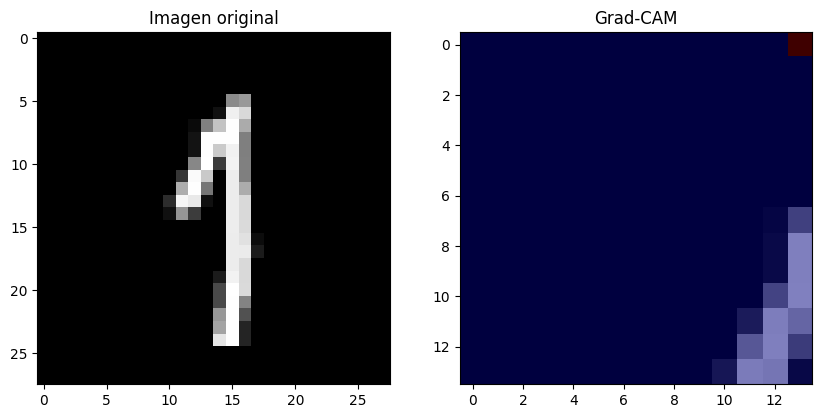

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(image[0][0].detach().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(image[0][0].detach().numpy(), cmap='gray')
plt.imshow(grad_cam, cmap='jet', alpha=0.5)  # Superponer Grad-CAM
plt.show()